# Validate a gridded height map with a reference gridded height map
ICESat-2 ATL08-derived gridded height map (30m) with reference lidar map

Paul Montesano  Feb 2023  
Use Review_biomass_output.ipynb to find and s3.download() tiles of interest, then transfer to ADAPT

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas
import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LinearSegmentedColormap000
#from matplotlib.colors import Normalize

import pandas as pd
import numpy as np
import plotnine
from plotnine import *

from sklearn.linear_model import LinearRegression

In [2]:
import sys
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import iolib, malib, geolib, filtlib, warplib

#### Functions

In [39]:
def plot_maps(masked_array_list, names_list, figsize=None, cmap_list=None, clim_list=None, title_text="", map_label='Reflectance (%)', COLORBAR_EXTEND_DIR='max'):
    
    if figsize is None:
        figsize = (len(names_list) * 7,5)
    
    fig, axa = plt.subplots( nrows=1, ncols=len(masked_array_list), figsize=figsize, sharex=False, sharey=False)

    for i, ma in enumerate(masked_array_list):
        
        if cmap_list is None:
            cmap = 'magma'
        else:
            cmap = cmap_list[i]
            
        if clim_list is None:
            clim = calcperc_nan(ma, perc=(1,95))
        else:
            clim = clim_list[i]

        f_name = names_list[i]
        
        if len(masked_array_list) == 1:
            axa = [axa]
        
        divider = make_axes_locatable(axa[i])
        cax = divider.append_axes('right', size='5.5%', pad=0.05)
        im1 = axa[i].imshow(ma, cmap=cmap , clim=clim )
        cb = fig.colorbar(im1, cax=cax, orientation='vertical', extend=COLORBAR_EXTEND_DIR)
        axa[i].set_title(title_text + os.path.split(f_name)[1], fontsize=7)
        cb.set_label(map_label)

        plt.tight_layout() 

def plot_hists(masked_array_list, names_list, figsize=None, title_text="", map_label='Reflectance (%)'):
    
    if figsize is None:
        figsize = (len(names_list) * 7,5)
    
    fig, axa = plt.subplots(nrows=1, ncols=len(masked_array_list), figsize=figsize, sharex=False, sharey=False)

    for i, ma in enumerate(masked_array_list):
        f_name = names_list[i]
        print(f" {ma.count()} valid pixels in INPUT MASKED ARRAY version of {f_name}")

        h = axa[i].hist(ma.compressed(), bins=256, alpha=0.75, facecolor='gray')
        axa[i].set_title(title_text + os.path.split(f_name)[1], fontsize=7)

    plt.tight_layout() 
    
def calcperc_nan(b, perc=(0.1,99.9)):
    """Calculate values at specified percentiles
    """
    b = malib.checkma(b)
    if b.count() > 0:
        low = np.nanpercentile(b.compressed(), perc[0])
        high = np.nanpercentile(b.compressed(), perc[1])
    else:
        low = 0
        high = 0
    return low, high

def set_ndv_to_nan(ma, ndv):
    ma[ma == ndv] = np.nan
    return ma

def get_ndv(r_fn):
    with rasterio.open(r_fn) as src:
        return src.profile['nodata']

# Set up dictionary for each validation site
sites can have reference lidar height maps, estimate height maps, reference lidar canopy cover maps

In [17]:
# Validation inputs
maindir = '/explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height'
OUTDIR = maindir

VAL_SERC2012_DICT = {
    'tile_num': 36024,
    'site_name': 'SERC',
    'ref_year': 2012,
    'r_fn_boreal_ht': os.path.join(maindir, 'boreal_ht_202212071670446291_36024.tif'),
    'r_fn_ref': os.path.join('/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GLiHT/Serc/SERC_Jun2012', 'SERC_Jun2012_CHM.tif'),
    'r_fn_cc': None
}
VAL_SERC2021_DICT = {
    'tile_num': 36024,
    'site_name': 'SERC',
    'ref_year': 2021,
    'r_fn_boreal_ht': os.path.join(maindir, 'boreal_ht_202212071670446291_36024.tif'),
    'r_fn_ref': os.path.join('/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GLiHT/Serc/MD_20210728_am_noon', 'MD_20210728_am_noon_SERC_CHM.tif'),
    'r_fn_cc': None
}

VAL_Howland2017_DICT = {
    'tile_num': 34443, #34210,
    'site_name': 'Howland',
    'ref_year': 2017,
    'r_fn_boreal_ht': os.path.join(maindir, 'boreal_ht_202212071670444237_34443.tif'),
    'r_fn_ref': os.path.join('/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GLiHT/Howland/ME_20170810_Howland_Forest', 'ME_20170810_Howland_Forest_CHM.tif'),
    'r_fn_cc': None
}

VAL_Bangor2012_DICT = {
    'tile_num': 34443, #34210,
    'site_name': 'Bangor',
    'ref_year': 2012,
    'r_fn_boreal_ht': os.path.join(maindir, 'boreal_ht_202212071670444237_34443.tif'),
    #'r_fn_ref': os.path.join('/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GLiHT/Howland/AMIGACarb_Bangor_FIA_Jun2012', 'AMIGACarb_Bangor_FIA_Jun2012_l44s592_CHM.tif')
    'r_fn_ref': os.path.join('/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GLiHT/Howland/AMIGACarb_Bangor_FIA_Jun2012', 'AMIGACarb_Bangor_FIA_Jun2012_l51s533_CHM.tif'),
    'r_fn_cc': None
}

VAL_AKLVIS2019_DICT = {
    'tile_num': 3458, #34210,
    'site_name': 'AKLVIS2019',
    'ref_year': 2019,
    'r_fn_boreal_ht': os.path.join(maindir, 
                                   #'boreal_ht_202407251721972696_003458.tif'# version 2
                                   'boreal_ht_202212071670446663_3458.tif' # version 1
                                  ),
    'r_fn_ref': os.path.join('/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30', 
                             'LVISF2_ABoVE2019_0722_R2003_063827_RH098_mean_30m.tif'),
                             #'LVISF2_ABoVE2019_0722_R2003_064002_RH098_mean_30m.tif'),
                             #'LVISF2_ABoVE2019_0725_R2003_084142_RH098_mean_30m.tif'),
    'r_fn_cc': os.path.join('/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30', 
                            'LVISF2_ABoVE2019_0722_R2003_063827_CC_gte_01p37m_30m.tif')
    
}

In [18]:
FIG_SIZE = (8,3)
FIG_SIZE_HIST = (8,1)
HT_CLIMS= (0, 25)

## Set your FOCAL SITE_DICT here

In [19]:
FOCAL_SITE_DICT = VAL_AKLVIS2019_DICT #VAL_Bangor2012_DICT # VAL_SERC2021_DICT# VAL_AKLVIS2019_DICT

In [20]:
# Reference height map from airborne lidar, estimated height map (from ML), reference canopy cover map
r_fn_ref, r_fn_boreal_ht, r_fn_cc = [FOCAL_SITE_DICT['r_fn_ref'], FOCAL_SITE_DICT['r_fn_boreal_ht'], FOCAL_SITE_DICT['r_fn_cc']]

if r_fn_cc is None:
    fn_list = [r_fn_ref, r_fn_boreal_ht]
else:
    fn_list = [r_fn_ref, r_fn_boreal_ht, r_fn_cc]

### Check the nodata values of each file

In [21]:
fn_list

['/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height/boreal_ht_202212071670446663_3458.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_CC_gte_01p37m_30m.tif']

In [22]:
ndv_list = [get_ndv(fn) for fn in fn_list]
ndv_list

[255.0, nan, 65535.0]

### Get the input arrays

In [23]:
ma_list = [iolib.fn_getma(fn) for fn in fn_list]

 58672 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_RH098_mean_30m.tif
 9000000 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height/boreal_ht_202212071670446663_3458.tif
 58672 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_CC_gte_01p37m_30m.tif


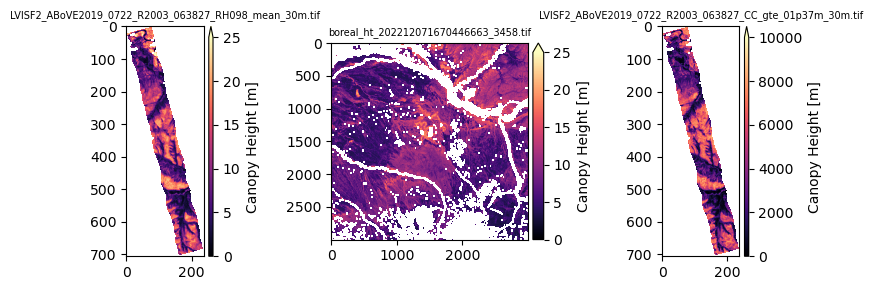

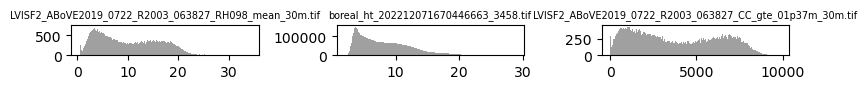

In [34]:
plot_maps(ma_list, fn_list, figsize=FIG_SIZE, clim_list = [HT_CLIMS, HT_CLIMS, (0,10000)], map_label='Canopy Height [m]')
plot_hists(ma_list, fn_list, figsize=FIG_SIZE_HIST)

In [62]:
# new_ma_list = [set_ndv_to_nan(ma, -9999.0) for ma in ma_list ]

# [ma.get_fill_value() for ma in new_ma_list]

## Warp the input data for stacking
to stack these images into a common grid (with an extent, projection, and resolution chosen from the input), use warplib  

In [36]:
get_ndv(r_fn_boreal_ht)

nan

In [37]:
# ---Doing the warp ---

# Here, the warped datasets and their arrays in these lists will be in the same order as your initial filenames list (fn_list)
warp_ds_list = warplib.memwarp_multi_fn(fn_list, res=r_fn_boreal_ht, extent='intersection', t_srs=r_fn_boreal_ht, r='near', dst_ndv=-9999)


Warping all inputs to the following:
Resolution: 30.0
Extent: [1510230.231015929, 3098828.0438816873, 1532581.0803582815, 3112274.1972225974]
Projection: '+proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'
Resampling alg: near

1 of 3: /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_RH098_mean_30m.tif
nl: 448 ns: 745 res: 30.000
0...10...20...30...40...50...60...70...80...90...2 of 3: /explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height/boreal_ht_202212071670446663_3458.tif
nl: 448 ns: 745 res: 30.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 3: /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_CC_gte_01p37m_30m.tif
nl: 448 ns: 745 res: 30.000
100 - done.
0...10...20...30...40...50...60...70...80...90...

### Get the warped arrays from the warped datasets

In [38]:
warp_ma_list = [iolib.ds_getma(ds) for ds in warp_ds_list]

### Check the valid range of each array
Note, after the warp (with 'near' resampling), the 0 values disappear - and mins change to 1

In [44]:
[warp_ma.get_fill_value() for warp_ma in warp_ma_list]

[-9999.0, -9999.0, 55537]

In [45]:
[calcperc_nan(ma, perc=(1,95)) for ma in warp_ma_list]

[(0.9271000003814698, 20.027199554443357),
 (3.7110176610946657, 17.27225275039673),
 (0.0, 5823.0)]

In [46]:
print('Input array mins/maxs')
[print(f'input ma min: {np.nanmin(ma)}') for ma in ma_list]
[print(f'input ma max: {np.nanmax(ma)}') for ma in ma_list]
print('Warped array mins/maxs')
[print(f'warped ma min: {np.nanmin(ma)}') for ma in warp_ma_list]
[print(f'warped ma max: {np.nanmax(ma)}') for ma in warp_ma_list]

Input array mins/maxs
input ma min: 0.49000000953674316
input ma min: 2.0721428394317627
input ma min: 0
input ma max: 34.2400016784668
input ma max: 28.749258041381836
input ma max: 9849
Warped array mins/maxs
warped ma min: 0.49000000953674316
warped ma min: 2.44773006439209
warped ma min: 0
warped ma max: 34.2400016784668
warped ma max: 26.488618850708008
warped ma max: 9849


[None, None, None]

### Warped masked arrays
maps & histograms

 58669 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_RH098_mean_30m.tif
 321212 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height/boreal_ht_202212071670446663_3458.tif


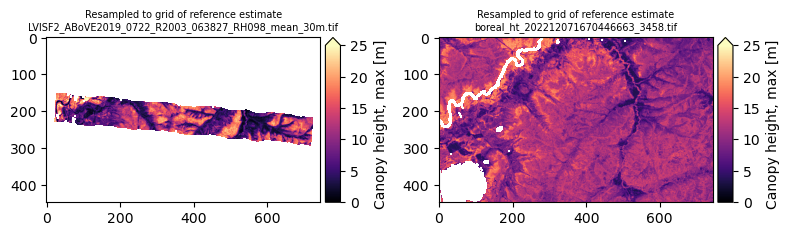

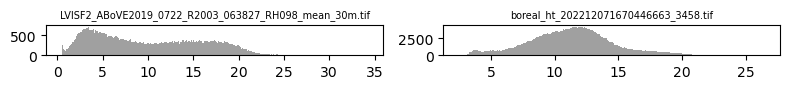

In [48]:
TITLE = 'Resampled to grid of reference estimate\n'
LABEL = 'Canopy height, max [m]'
plot_maps(warp_ma_list[0:2], fn_list[0:2], clim_list = [HT_CLIMS, HT_CLIMS], title_text = TITLE, map_label=LABEL, figsize=FIG_SIZE) 
plot_hists(warp_ma_list[0:2], fn_list[0:2], title_text = '', map_label=LABEL, figsize=FIG_SIZE_HIST) 

### Get a common mask of valid data from the inputs

In [49]:
# Mask negative values in input
warp_valid_ma_list = [ np.ma.masked_where(ma < 0, np.ma.masked_invalid(ma)) for ma in warp_ma_list]


common_mask = malib.common_mask(warp_valid_ma_list)
common_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

### Warped masked arays with common mask applied
now, each input should have same exact dimensions, grid, projection. They ony differ in their values (CCDC is surface reflectance, EVHR is TOA reflectance)  
maps and histograms

 58105 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_RH098_mean_30m.tif
 58105 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height/boreal_ht_202212071670446663_3458.tif
 58105 valid pixels in INPUT MASKED ARRAY version of /explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_063827_CC_gte_01p37m_30m.tif


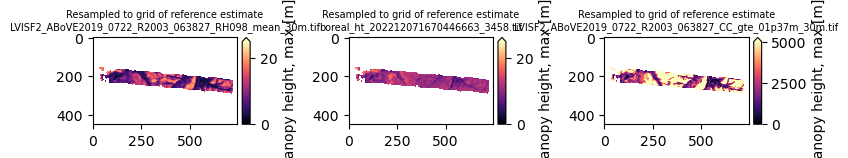

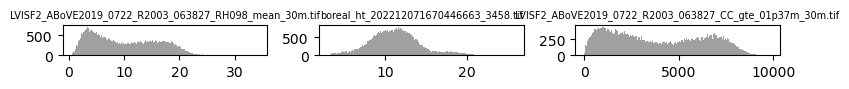

In [64]:
warp_ma_masked_list = [np.ma.array(ma, mask=common_mask) for ma in warp_ma_list]

plot_maps(warp_ma_masked_list[0:3], fn_list[0:3], clim_list = [(0,25), (0,25), (0,5e3)], title_text = TITLE, map_label=LABEL, figsize=FIG_SIZE)
plot_hists(warp_ma_masked_list[0:3], fn_list[0:3],  title_text = '', figsize=FIG_SIZE_HIST)

#### Prep the x and y data

In [66]:
# Reference is first element in list, which needs to be the y-var: b/c we are predicting SR from TOA
ref_x_var, atl08_y_var, ref_tcc = [ma.ravel() for ma in warp_ma_masked_list]

y_var = atl08_y_var[atl08_y_var.mask == False]
x_var = ref_x_var[ref_x_var.mask == False]
tcc_var = ref_tcc[ref_tcc.mask == False]

#### Scatterplot (binned)

/tmp/ipykernel_997725/2667545770.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.


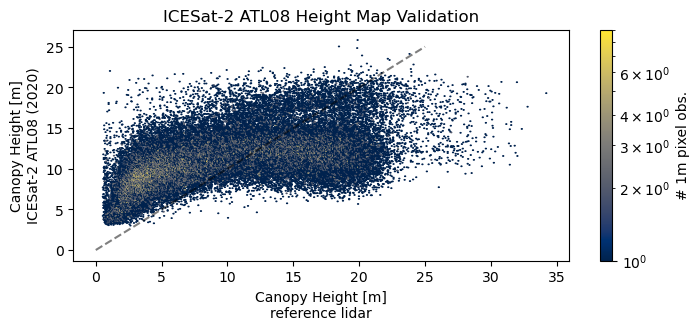

In [55]:
figsize=(6,6)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=FIG_SIZE, sharex=True, sharey=True)

hb = ax.hexbin(x_var.ravel().data, y_var.ravel().data, gridsize=500, 
               bins='log',
               cmap='cividis')
#ax.axis([x_var.min(), x_var.max(), y_var.min(), y_var.max()])
ax.plot((0,25), (0,25), 'k-', alpha=0.5, zorder=1, linestyle='--')
ax.set_title("ICESat-2 ATL08 Height Map Validation")
plt.xlabel("Canopy Height [m]\nreference lidar")
plt.ylabel("Canopy Height [m]\nICESat-2 ATL08 (2020)")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('# 1m pixel obs.')

##### Overestimation / Underestimation of ICESat-2 ATL08 30m height map in temperate forest

`Blue` shows UNDERESTIMATION

Diff array mins/maxs
Diff ma min: -20.91103744506836
Diff ma max: 20.976566314697266


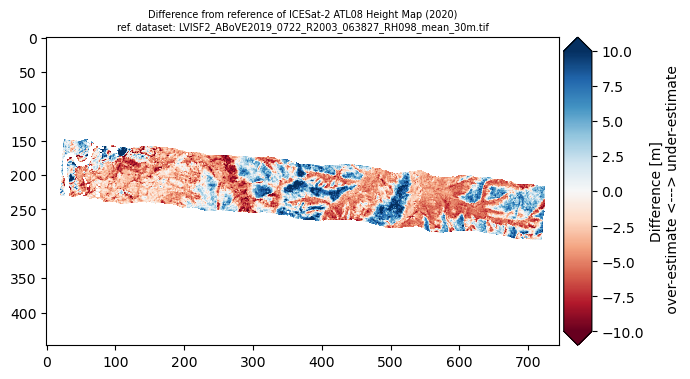

In [56]:
# Difference Map
diff_ma = warp_ma_masked_list[0]-warp_ma_masked_list[1]

print('Diff array mins/maxs')
print(f'Diff ma min: {np.nanmin(diff_ma)}')
print(f'Diff ma max: {np.nanmax(diff_ma)}') 

plot_maps([diff_ma], [''], title_text='Difference from reference of ICESat-2 ATL08 Height Map (2020)\n' + 'ref. dataset: ' + os.path.basename(r_fn_ref), clim_list = [(-10,10)], 
          cmap_list=['RdBu'],
          map_label = 'Difference [m]\n over-estimate <---> under-estimate',
          COLORBAR_EXTEND_DIR='both'
         )

In [67]:
df_ht_val = pd.DataFrame(data = np.transpose([y_var,x_var,tcc_var]), columns=['ht_m_atl08','ht_m_ref','tcc_ref'])
df_ht_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58105 entries, 0 to 58104
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ht_m_atl08  58105 non-null  float32
 1   ht_m_ref    58105 non-null  float32
 2   tcc_ref     58105 non-null  float32
dtypes: float32(3)
memory usage: 681.0 KB


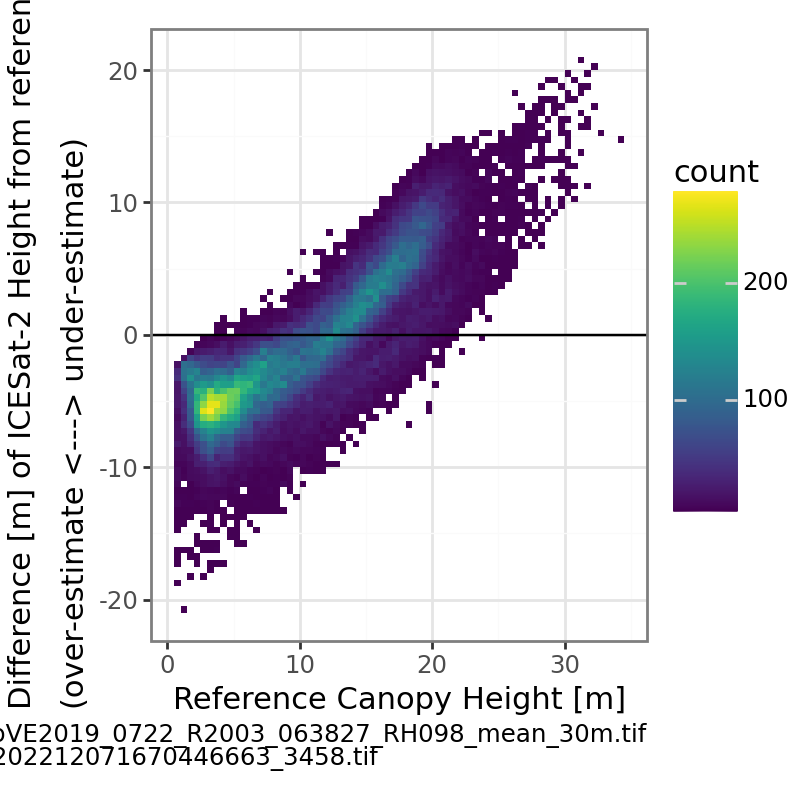

In [58]:
plotnine.options.figure_size = (4, 4)

tmp_df = df_ht_val.sample(frac=1)
(
        ggplot(tmp_df, aes(x=tmp_df["ht_m_ref"], y=tmp_df["ht_m_ref"]-tmp_df['ht_m_atl08']))
        + labs(title='', x='Reference Canopy Height [m]', y='Difference [m] of ICESat-2 Height from reference\n\n(over-estimate <---> under-estimate)', caption = os.path.basename(r_fn_ref) +'\n' + os.path.basename(r_fn_boreal_ht))
        + geom_bin2d(binwidth=0.5)
        + geom_hline(yintercept=0)
        + theme_bw()
    +coord_equal()
)

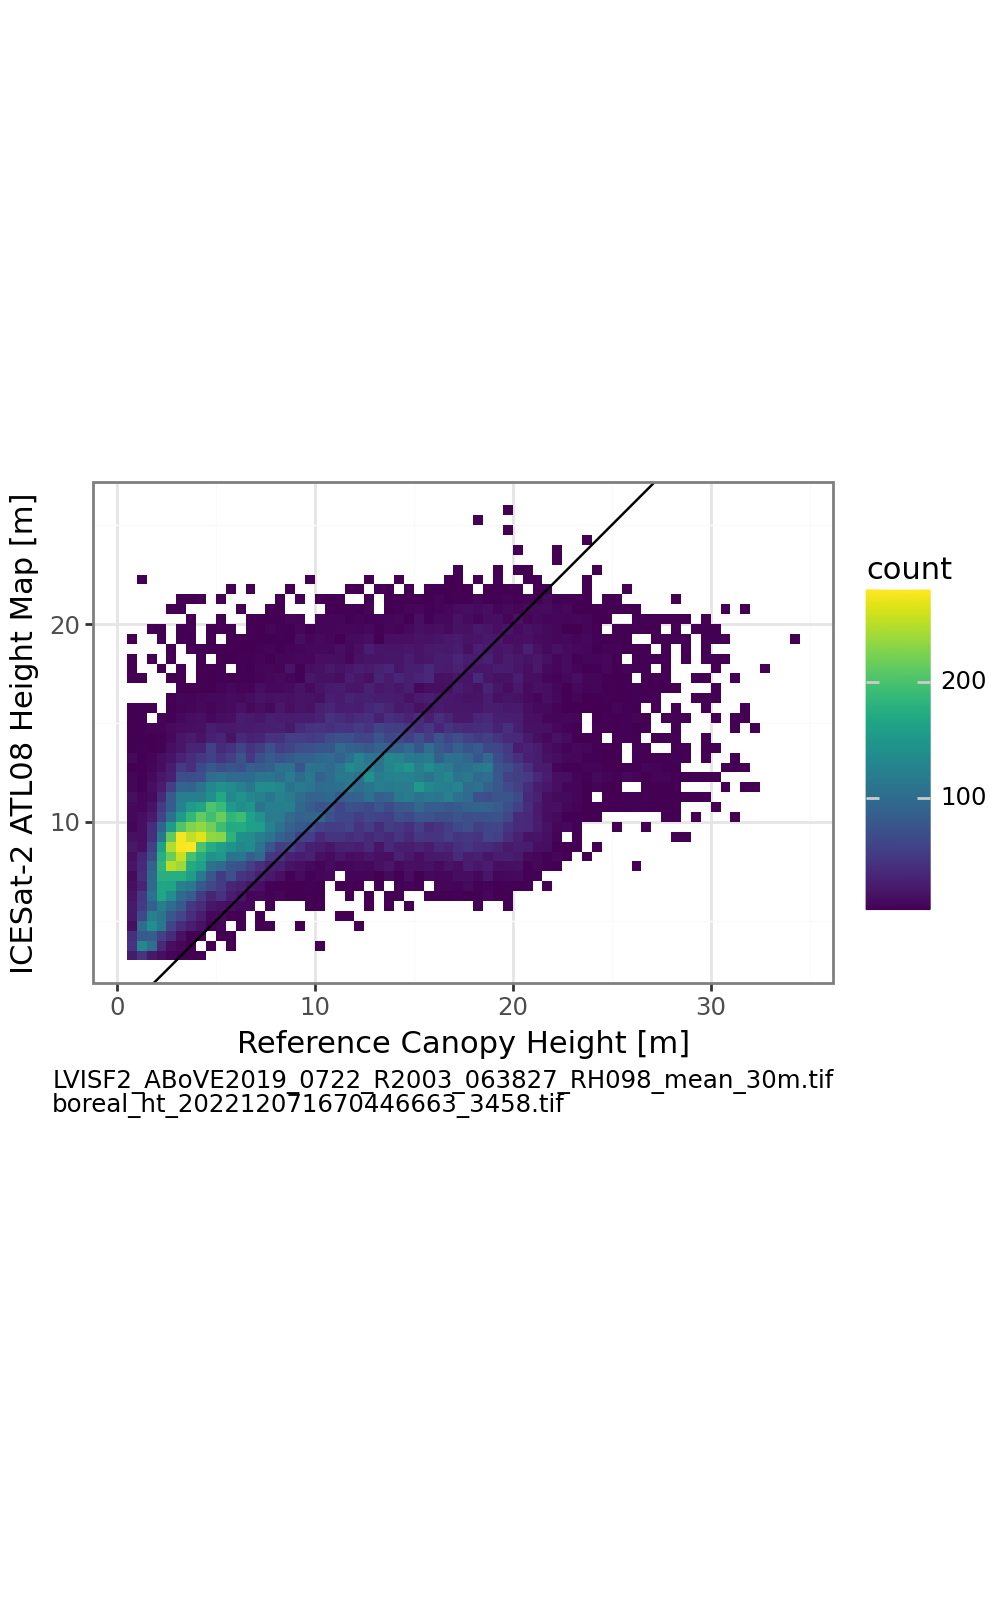

In [59]:
plotnine.options.figure_size = (5, 8)

(
        ggplot(tmp_df, aes(x=tmp_df["ht_m_ref"], y=tmp_df['ht_m_atl08']))
        + labs(title='', x='Reference Canopy Height [m]', y='ICESat-2 ATL08 Height Map [m]', caption = os.path.basename(r_fn_ref) +'\n' + os.path.basename(r_fn_boreal_ht))
        + geom_bin2d(binwidth=0.5)
    #+ scale_y_log10()
    #+ scale_x_log10()
        + geom_abline()
        + theme_bw()
    +coord_equal()
)

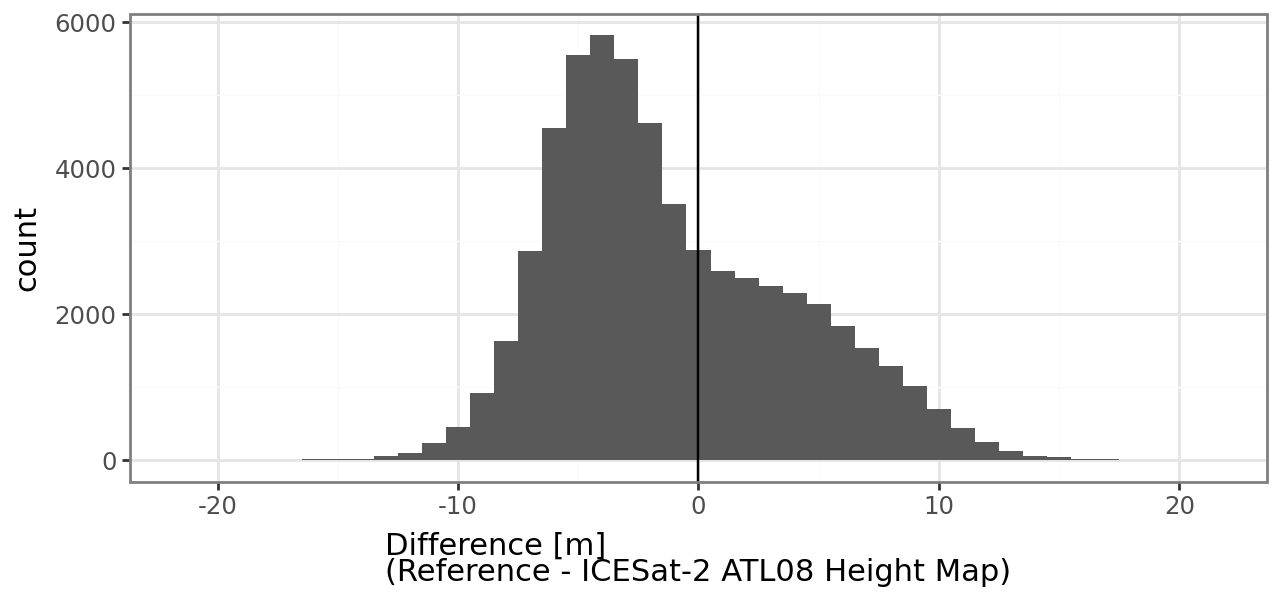

In [60]:
plotnine.options.figure_size = (6.4, 3)
(
        ggplot(tmp_df, aes(x=tmp_df["ht_m_ref"]-tmp_df['ht_m_atl08']))
        + labs(title='', x='Difference [m]\n(Reference - ICESat-2 ATL08 Height Map)')
        + geom_histogram(binwidth=1)
        + geom_vline(xintercept=0)
        + theme_bw()
)

In [61]:
diff_arr = df_ht_val['ht_m_ref']-df_ht_val['ht_m_atl08']
print(f"Median of diffs:   {diff_arr.median() }")
print(f"Mean of diffs:     {diff_arr.mean()   }")
print(f"Variance of diffs: {diff_arr.std()    }")

Median of diffs:   -2.2533493041992188
Mean of diffs:     -1.1058422327041626
Variance of diffs: 5.047616481781006
